# Gene Expression analysis example framework. 

## Load libraries

In [2]:
library(DESeq2)
library(clusterProfiler)
library(org.Hs.eg.db)
library(ggplot2)
library(ComplexHeatmap)
library(tidyverse)
library(repr)
library(reshape2)
library(biomaRt)
library(magrittr)
library(EnhancedVolcano)


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics




Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package

## Using Test/artificial data or data from nf-core rnaseq pipeline:

Do you want to use test/artificial data? If you want to use your data, put test to FALSE and edit the second part of if statement and include your file location. 


In [3]:
test = TRUE 
ensembl_fake_names= TRUE


if (test == TRUE) {
    # Set seed for reproducibility
  set.seed(123)

  # Number of rows (genes) and columns (samples)
  n_rows <- 15125  # Number of genes
  n_cols <- 6      # Number of samples (3 replicates per condition)

  # Initialize a matrix for gene counts
  gene_counts <- matrix(0, nrow = n_rows, ncol = n_cols)

  # Generate similar values for the first 3 columns (Condition A - Treated)
  gene_counts[, 1:3] <- matrix(sample(50:100, n_rows * 3, replace = TRUE), ncol = 3)

  # Generate similar values for the last 3 columns (Condition B - Control)
  gene_counts[, 4:6] <- matrix(sample(200:300, n_rows * 3, replace = TRUE), ncol = 3)

  # Introduce differential expression in a subset of genes (e.g., 100 genes)
  de_rows <- sample(1:n_rows, 200)

  # Decrease counts in Condition A for DE genes
  gene_counts[de_rows, 1:3] <- gene_counts[de_rows, 1:3] / 6  # Strong down-regulation in Treated condition

  # Increase counts in Condition B for DE genes
  gene_counts[de_rows, 4:6] <- gene_counts[de_rows, 4:6] * 6  # Strong up-regulation in Control condition

  # Convert to data frame for DESeq2
  gene_counts <- as.data.frame(gene_counts)

  # Rename columns to reflect conditions and replicates
  colnames(gene_counts) <- c("Treated_Rep1", "Treated_Rep2", "Treated_Rep3", "Control_Rep1", "Control_Rep2", "Control_Rep3")

  # Assign row names as gene names
  rownames(gene_counts) <- paste0("Gene_", 1:n_rows)
  
  if (ensembl_fake_names == TRUE) {
    # Initialize the Ensembl mart for Homo sapiens (you can change the species if needed)
    ensembl <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")

    # Get the gene symbols for a certain number of genes (e.g., 10,125 genes)
    # You can adjust the filters and attributes if you want different gene info
    genes_data <- getBM(
      attributes = c('ensembl_gene_id', 'hgnc_symbol'),  # Ensembl IDs and gene symbols
      filters = 'biotype',
      values = 'protein_coding',  # Only protein-coding genes
      mart = ensembl,
      uniqueRows = TRUE
    )

    # Get the top 10125 gene symbols (or adjust if you have more)
    gene_symbols <- genes_data$hgnc_symbol[1:n_rows]

    # In case of missing gene symbols (""), replace with Ensembl IDs or generic names
    gene_symbols[gene_symbols == ""] <- genes_data$ensembl_gene_id[gene_symbols == ""]

    # Ensure the list is long enough to replace all gene names
    if (length(gene_symbols) < n_rows) {
      gene_symbols <- c(gene_symbols, paste0("Gene_", (length(gene_symbols) + 1):n_rows))
    }

    # Make gene names unique
    gene_symbols <- make.unique(gene_symbols)

    # Assign the unique gene names to row names
    rownames(gene_counts) <- gene_symbols

  }


  # Create colData (metadata for samples)
  col_data <- data.frame(
    condition = rep(c("Treated", "Control"), each = 3),  # 3 replicates for each condition
    row.names = colnames(gene_counts)
  )

  # Ensure gene counts are integers for DESeq2
  gene_counts[] <- lapply(gene_counts, as.integer)

  # Check if column names of gene_counts match row names of colData
  all(colnames(gene_counts) == rownames(col_data))  # Should return TRUE

  # View summary of generated data
  summary(gene_counts)

}else if (test == FALSE) {
    # Assuming you have a directory where Salmon output files are stored
    salmon_dir <- "/workspaces/Atai_rnaseq_bulk/nf_rnaseq_successful_run/star_salmon/"

    # Path to gene-level quantification file
    gene_counts_file <- file.path(salmon_dir, "salmon.merged.gene_counts.tsv")
    gene_tpm_file <- file.path(salmon_dir, "salmon.merged.gene_tpm.tsv")

    # Load gene counts
    gene_counts <- read.table(gene_counts_file, header = TRUE, row.names = 1)

    # Load TPM values
    gene_tpm <- read.table(gene_tpm_file, header = TRUE, row.names = 1)

} else {
  print("NO INPUT")

}


Warning message in gene_symbols[gene_symbols == ""] <- genes_data$ensembl_gene_id[gene_symbols == :
“number of items to replace is not a multiple of replacement length”


  Treated_Rep1     Treated_Rep2     Treated_Rep3     Control_Rep1   
 Min.   :  8.00   Min.   :  8.00   Min.   :  8.00   Min.   : 200.0  
 1st Qu.: 62.00   1st Qu.: 62.00   1st Qu.: 62.00   1st Qu.: 225.0  
 Median : 75.00   Median : 75.00   Median : 75.00   Median : 251.0  
 Mean   : 74.23   Mean   : 74.07   Mean   : 74.18   Mean   : 266.7  
 3rd Qu.: 88.00   3rd Qu.: 87.00   3rd Qu.: 88.00   3rd Qu.: 276.0  
 Max.   :100.00   Max.   :100.00   Max.   :100.00   Max.   :1794.0  
  Control_Rep2     Control_Rep3   
 Min.   : 200.0   Min.   : 200.0  
 1st Qu.: 225.0   1st Qu.: 225.0  
 Median : 251.0   Median : 251.0  
 Mean   : 266.4   Mean   : 266.6  
 3rd Qu.: 276.0   3rd Qu.: 276.0  
 Max.   :1800.0   Max.   :1800.0  

In [4]:
head(gene_counts)

,Treated_Rep1,Treated_Rep2,Treated_Rep3,Control_Rep1,Control_Rep2,Control_Rep3
,<int>,<int>,<int>,<int>,<int>,<int>
MT-ND1,80,73,67,243,210,235
MT-ND2,64,95,94,231,251,262
MT-CO1,100,53,55,251,299,220
MT-CO2,63,93,58,239,251,271
MT-ATP8,52,66,75,239,230,255
MT-ATP6,15,9,8,1554,1362,1494


# Data Check

[1] 15125     6

     Gene                   variable         value       
 Length:90750       Treated_Rep1:15125   Min.   :   8.0  
 Class :character   Treated_Rep2:15125   1st Qu.:  75.0  
 Mode  :character   Treated_Rep3:15125   Median : 150.0  
                    Control_Rep1:15125   Mean   : 170.4  
                    Control_Rep2:15125   3rd Qu.: 251.0  
                    Control_Rep3:15125   Max.   :1800.0  

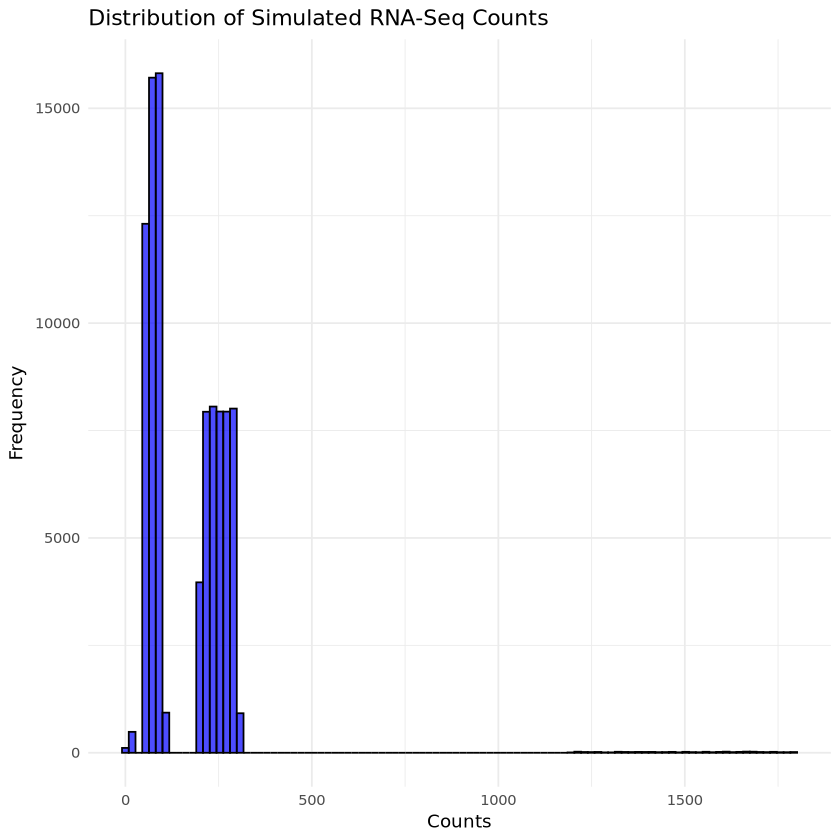

In [5]:
dim(gene_counts)

# Convert counts to a data frame for ggplot2
counts_df <- as.data.frame(gene_counts)
counts_df$Gene <- rownames(counts_df)

# Melt the data frame for plotting
counts_melted <- melt(counts_df, id.vars = "Gene")

# Plot the distribution of counts with more bins without log scale
ggplot(counts_melted, aes(x = value)) +
  geom_histogram(bins = 100, fill = "blue", color = "black", alpha = 0.7) +
  labs(
    title = "Distribution of Simulated RNA-Seq Counts",
    x = "Counts",
    y = "Frequency"
  ) +
  theme_minimal()

summary(counts_melted)

# Differential Expression Analysis

Review the code line by line. More information: 
https://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html


In [6]:

# Create DESeqDataSet object
dds <- DESeqDataSetFromMatrix(countData = gene_counts,
                              colData = col_data,
                              design = ~ condition)


# Perform differential expression analysis
dds <- DESeq(dds)

# Get differential expression results
res <- results(dds)

# Assuming padj is adjusted p-values column in res
res$significant <- ifelse(res$padj < 0.05, "Significant", "Not Significant")

# Optionally, order results by adjusted p-value (for better visualization)
res <- res[order(res$padj), ]

# Filter for significant results based on adjusted p-value
# res_sig will contain only rows where padj < 0.05
res_sig <- res[which(res$padj < 0.05), ]
# or
# Filter based on both padj and log2FoldChange thresholds
res_sig <- res[which(res$padj < 0.05 & abs(res$log2FoldChange) > 1), ]



Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



# Volcano plots

Various volcano plots to visualize our data.  

Warning message:
“Removed 10850 rows containing missing values or values outside the scale range
(`geom_point()`).”


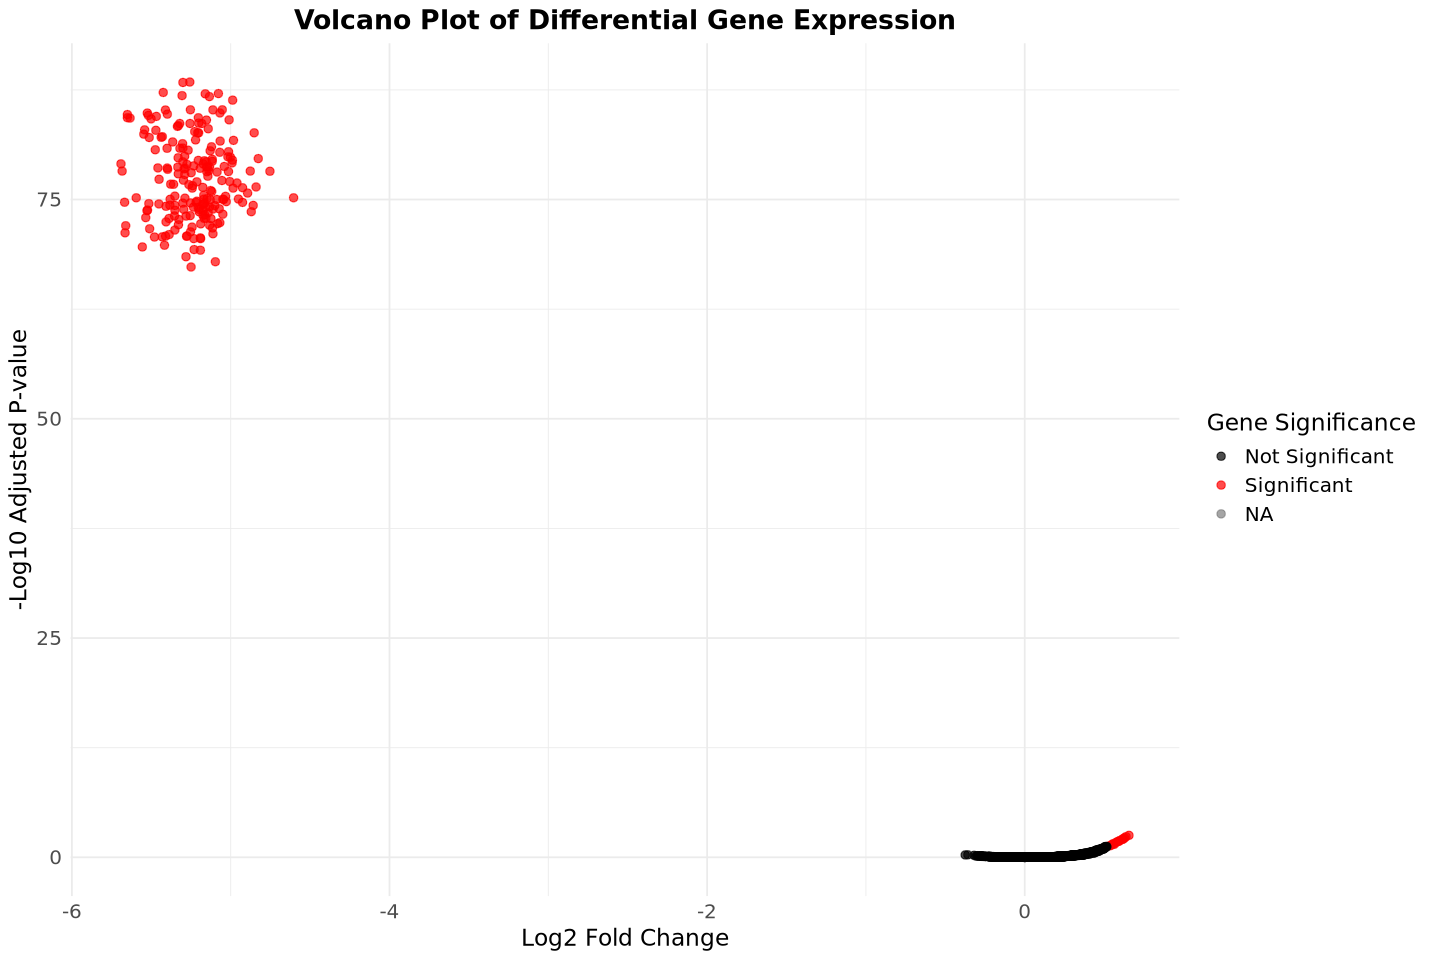

In [7]:

# Set default plot size for Jupyter Notebook
options(repr.plot.width = 12, repr.plot.height = 8)

# Generate the plot
volcano_plot <- ggplot(res, aes(x = log2FoldChange, y = -log10(padj), color = significant)) +
  geom_point(size = 2, alpha = 0.7) +
  scale_color_manual(values = c("black", "red")) +
  theme_minimal() +
  labs(
    title = "Volcano Plot of Differential Gene Expression",
    x = "Log2 Fold Change",
    y = "-Log10 Adjusted P-value",
    color = "Gene Significance"
  ) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12),
    legend.title = element_text(size = 14),
    legend.text = element_text(size = 12)
  )

# Print the plot to view it in the increased size
print(volcano_plot)


Warning message:
“ggrepel: 200 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


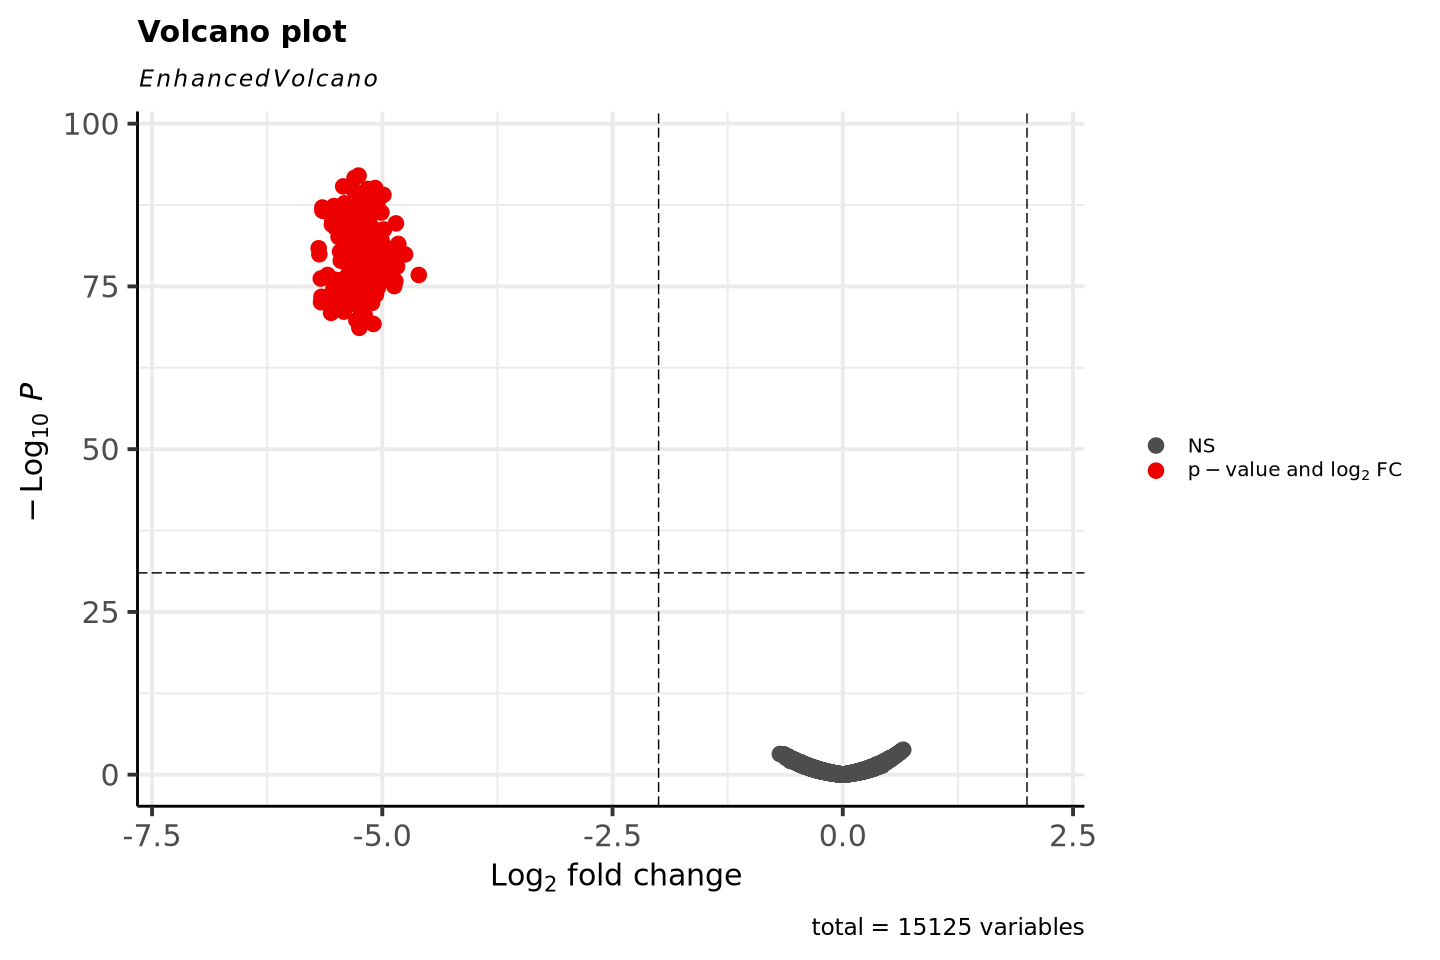

In [8]:
## Advance Volcano plots: 
# https://github.com/kevinblighe/EnhancedVolcano

  # create custom key-value pairs for 'high', 'low', 'mid' expression by fold-change
  # this can be achieved with nested ifelse statements

EnhancedVolcano(res,
    lab = rownames(res),
    x = 'log2FoldChange',
    y = 'pvalue',
    xlab = bquote(~Log[2]~ 'fold change'),
    pCutoff = 10e-32,
    FCcutoff = 2.0,
    pointSize = 4.0,
    labSize = 6.0,
    colAlpha = 1,
    legendPosition = 'right',
    legendLabSize = 12,
    legendIconSize = 4.0,
    drawConnectors = TRUE,
    widthConnectors = 0.75)

# PCA

principal components analysis (PCA) plot

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

using ntop=500 top features by variance



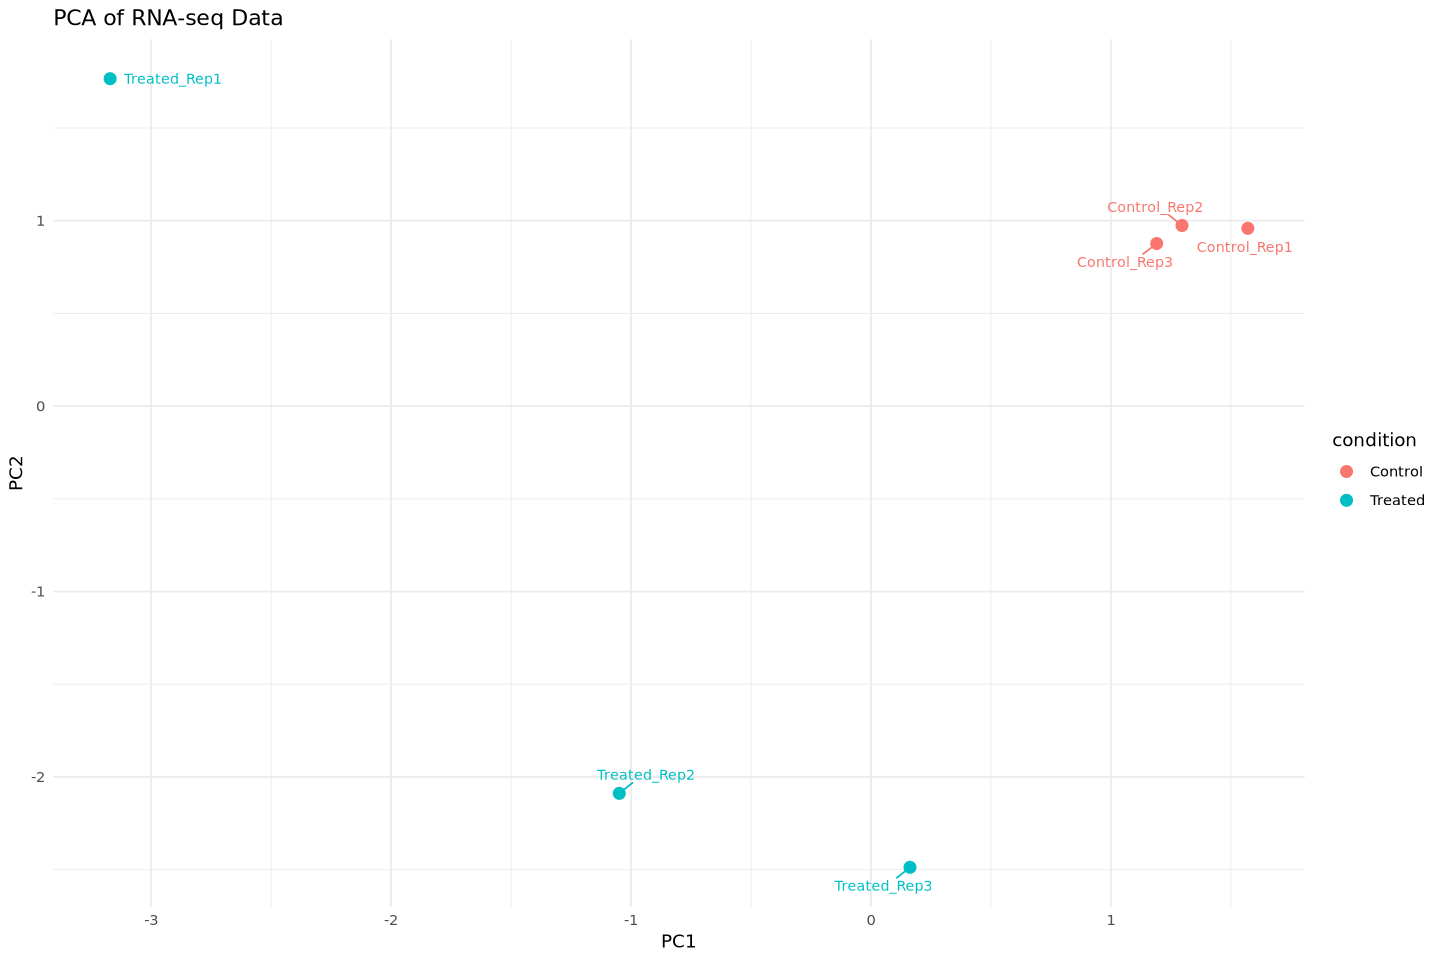

In [9]:
# Normalize counts for PCA
rld <- rlog(dds)

# Perform PCA
pca_data <- plotPCA(rld, intgroup = "condition", returnData = TRUE)

# Plot PCA with sample labels
ggplot(pca_data, aes(x = PC1, y = PC2, color = condition, label = rownames(pca_data))) +
  geom_point(size = 3) +
  geom_text_repel(aes(label = rownames(pca_data)), size = 3, box.padding = 0.5) +  # Add text labels with repulsion to avoid overlap
  theme_minimal() +
  labs(title = "PCA of RNA-seq Data") +
  theme(
    legend.position = "right"  # Adjust legend position if needed
  )

# Heatmaps

Prepare heatmaps to visualize clusters of samples and genes.  

Warning message:
“The input is a data frame-like object, convert it to a matrix.”
The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.



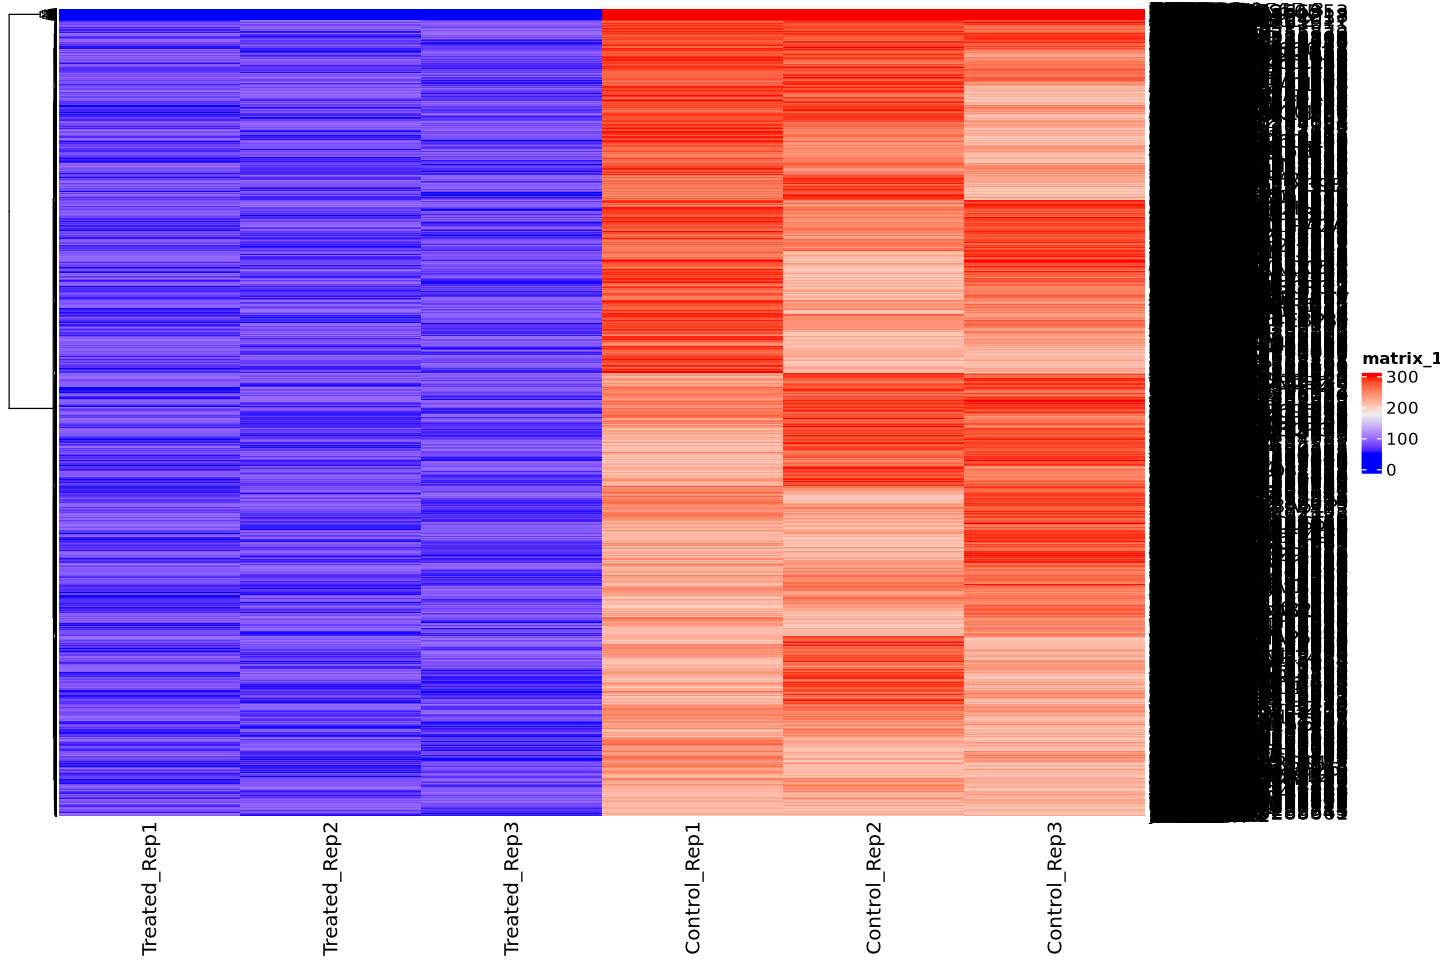

In [10]:
# Prepare data for heatmap (e.g., top differentially expressed genes)
# top_genes <- head(rownames(res_sig), 50) # Example: top 50 genes
# heatmap_data <- gene_counts[top_genes, ]
heatmap_data <- gene_counts[, ]

# Create heatmap
Heatmap(heatmap_data, cluster_rows = TRUE, cluster_columns = FALSE)


# Functional Analysis


In [11]:
# Assuming 'res_sig' contains significantly differentially expressed genes


# Convert gene symbols to Entrez IDs if needed
# Example: gene_ids <- mapIds(org.Hs.eg.db, rownames(res_sig), "ENTREZID", "SYMBOL")

# Perform GO enrichment analysis
go_enrich <- enrichGO(gene = rownames(res_sig),
                      OrgDb = org.Hs.eg.db, 
                      keyType = "SYMBOL", # ENTREZID
                      ont = "BP",
                      pvalueCutoff = 0.05,
                      qvalueCutoff = 0.05)

# Visualize GO enrichment results
dotplot(go_enrich, showCategory = 20)


Warning message in rep(yes, length.out = len):
“'x' is NULL so the result will be NULL”
ERROR while rich displaying an object: Error in ans[ypos] <- rep(yes, length.out = len)[ypos]: replacement has length zero

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr

# Pathway Analysis


In [12]:
# rename some data. 
library(org.Hs.eg.db)

# Assuming rownames(res_sig) are gene symbols
gene_symbols <- rownames(res_sig)

# Convert gene symbols to Entrez IDs
gene_entrez_ids <- mapIds(org.Hs.eg.db, 
                          keys = gene_symbols, 
                          column = "ENTREZID", 
                          keytype = "SYMBOL", 
                          multiVals = "first")

# Remove any NA values
gene_entrez_ids <- na.omit(gene_entrez_ids)


'select()' returned 1:1 mapping between keys and columns



In [13]:
gene_df <- data.frame(
  gene_name = names(gene_entrez_ids),  # Gene names from the names attribute
  gene_id = as.character(gene_entrez_ids),  # Entrez IDs as character
  stringsAsFactors = FALSE  # Avoid factors to keep it character
)

# Display the first few rows of the data frame
head(gene_df)

# Accessing all gene IDs
all_gene_ids <- gene_df$gene_id

# Print all gene IDs
head(all_gene_ids)


,gene_name,gene_id
,<chr>,<chr>
1,WAC,51322
2,SLC39A6,25800
3,ZNF569,148266
4,ACACA,31
5,SLC27A6,28965
6,LILRA3,11026


[1] "51322"  "25800"  "148266" "31"     "28965"  "11026"

In [14]:
library(clusterProfiler)

# Example of using enrichKEGG
kegg_enrich <- enrichKEGG(gene = all_gene_ids, organism = "hsa", pvalueCutoff = 0.05, qvalueCutoff = 0.05)

# Check if kegg_enrich is not NULL
if (!is.null(kegg_enrich) && nrow(kegg_enrich) > 0) {
    dotplot(kegg_enrich, showCategory = 20)  # Create the dotplot if results exist
} else {
    print("No KEGG enrichment results to display.")
}


Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...



[1] "No KEGG enrichment results to display."


# Integration with more omics data

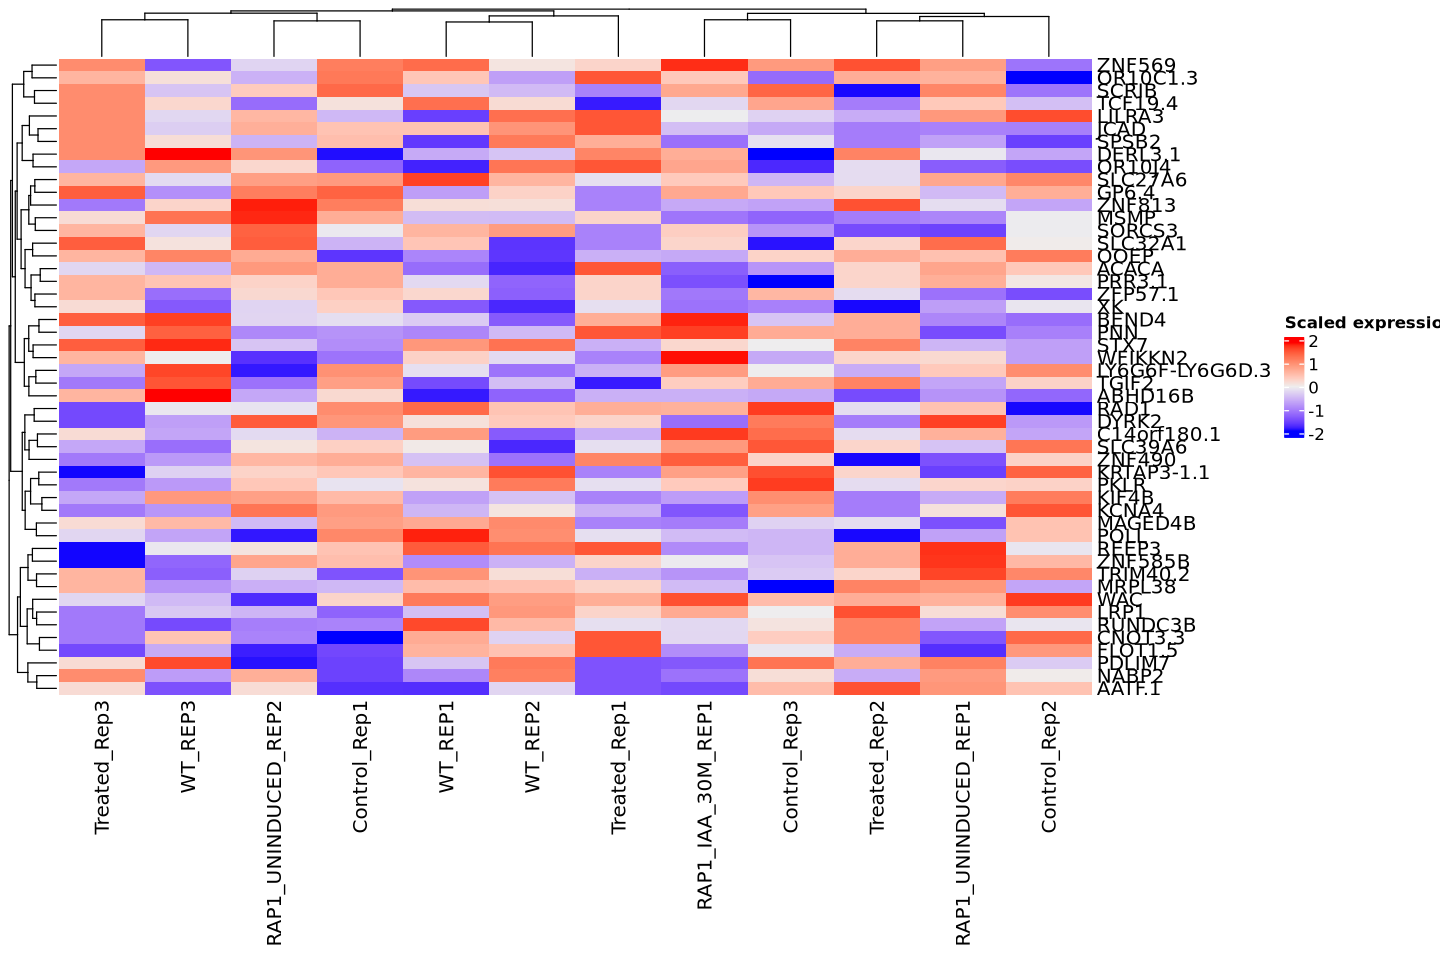

In [15]:
# Create SYNTHETIC proteomics data
top_genes <- head(rownames(res_sig), 50) # Example: top 50 genes
proteomics_data <- as.data.frame(matrix(runif(50 * 6, 0, 100), ncol = 6))

# name columns
colnames(proteomics_data) <- c("RAP1_IAA_30M_REP1", "RAP1_UNINDUCED_REP1", "RAP1_UNINDUCED_REP2", "WT_REP1", "WT_REP2", "WT_REP3")
rownames(proteomics_data) <- paste0("Protein_", 1:50)

# Combine RNA-seq and proteomics data for integration
combined_data <- cbind(gene_counts[top_genes, ], proteomics_data[1:50, ])
combined_data <- scale(combined_data)

# Create heatmap of combined data
Heatmap(combined_data, name = "Scaled expression", cluster_rows = TRUE, cluster_columns = TRUE)


# Appendix: 
Example based on Rik's presentation

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



,Treated_Rep1,Treated_Rep2,Treated_Rep3,Control_Rep1,Control_Rep2,Control_Rep3
KRTAP3-1.1,6.790922,6.894535,6.713936,10.010630,10.085398,10.096904
KCNA4,6.826601,6.792217,6.791549,10.055579,10.094034,10.044456
KIF4B,6.790922,6.792217,6.827257,10.024263,10.067968,10.057749
OR11A1.5,6.790922,6.792217,6.753886,10.068793,9.860762,10.105462
TGIF2,6.713371,6.955772,6.791549,10.051147,9.996045,10.035525
LY6G6F-LY6G6D.3,6.826601,6.827955,6.827257,10.064402,10.054755,9.980734
SCRIB,6.790922,6.714537,6.954967,10.099159,9.875885,10.083971
DYRK2,6.893072,6.792217,6.753886,10.059997,9.905658,10.070920
LMO7,6.826601,6.714537,6.753886,9.978304,10.027957,9.884477
POLL,6.860583,6.714537,6.861266,10.073171,10.009809,9.943006


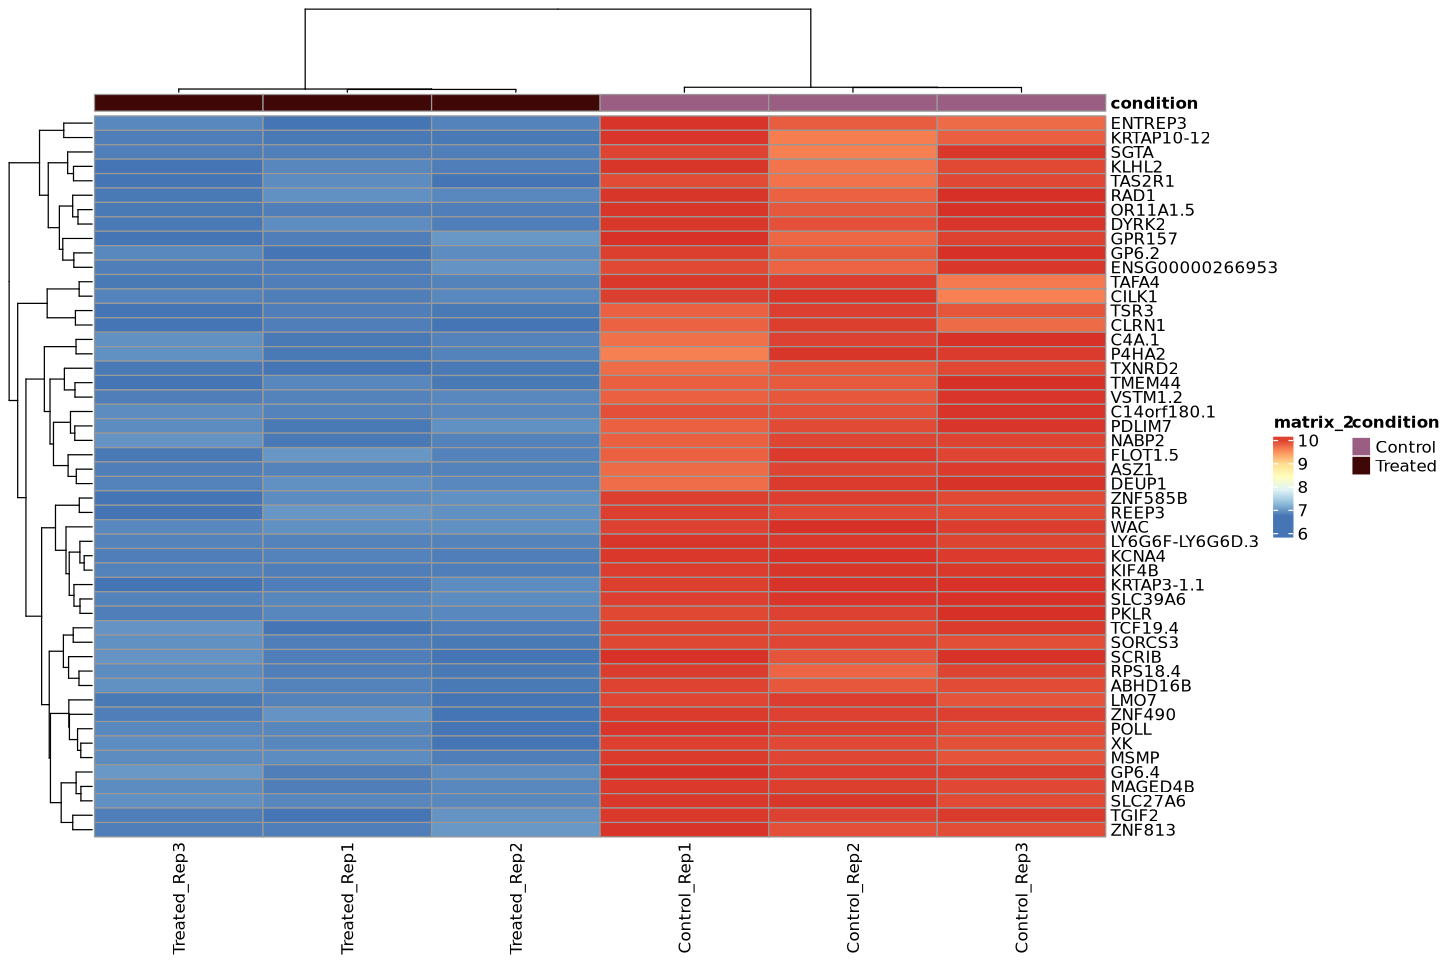

In [16]:
# Create DESeq2 dataset
dds <- DESeqDataSetFromMatrix(countData = gene_counts,
                              colData = col_data,
                              design = ~ condition)

# dds <- DESeqDataSetFromMatrix(countData = countData, colData = colData, design = ~ condition)

# Run DESeq2 analysis
dds <- DESeq(dds)
res <- results(dds)

## Extract normalized counts for heatmap using variance stabilizing transformation
vsd <- varianceStabilizingTransformation(dds, blind=FALSE)
mat <- assay(vsd)

##  Select top 50 genes by variance for heatmap
topVarGenes <- head(order(rowVars(mat), decreasing=TRUE), 50)
mat <- mat[topVarGenes, ]
mat
## Plot heatmap
pheatmap(mat, cluster_rows=TRUE, cluster_cols=TRUE, show_rownames=TRUE, annotation_col=col_data) 

